# Closed-forms for 1-Wasserstein Distance

In [1]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from itertools import product
import os
import pickle as pkl

import numpy as np
# import ot
import scipy.stats as st
from scipy.special import gamma as Γ

os.chdir('../')
plt.style.use('scripts/thesis.mplstyle')
cpal = plt.rcParams['axes.prop_cycle'].by_key()['color']
ls = plt.rcParams['axes.prop_cycle'].by_key()['linestyle']
mark = plt.rcParams['axes.prop_cycle'].by_key()['marker']

## Univariate Location-Scale Distributions


|Distribution | $W_1(X_1,X_2)/\mathbb{E}[\lvert Y \rvert]$ | Note |
| --- | --- | --- |
|Uniform  | $\displaystyle \begin{align}     \frac{1}{2}\left(\lvert a_y \rvert + \lvert b_y \rvert \right), a_y \text{ \& } b_y \geq 0 \text{ or } \leq 0 \\      \frac{1}{2}\left(\frac{a_y^2 + b_y^2}{b_y-a_y}\right), \quad \text{otherwise} \end{align}$  | $Y \sim \alpha_y + \beta_y Z_{U} = U(a_y,a_y + b_y)$. The conventional upper and lower bounds of the uniform distribution $Y$ are $a_y = \min\left((\alpha_1 - \alpha_2), (\beta_1 - \beta_2) + (\alpha_1 - \alpha_2)\right) , b_y = \max\left((\alpha_1 - \alpha_2), (\beta_1 - \beta_2) + (\alpha_1 - \alpha_2)\right) $. |
|Gaussian | $\displaystyle \alpha_y \left[ 1- 2 \Phi_{N}\left(-\frac{\alpha_y}{\beta_y}\right) \right] + \beta_y \sqrt{\frac{2}{\pi}} \exp{\left(-\frac{\left(\beta_y\right)^2}{2\left(\beta_y\right)^2}\right)}$ | |
|Laplace | $\displaystyle \alpha_y + \beta_y \exp{\left(-\frac{\alpha_y}{\beta_y}\right)} $ | |
|Logistic | $\displaystyle \alpha_y + 2\beta_y \ln{\left( 1 + \exp{\left(-\frac{\alpha_y}{\beta_y}\right)} \right)}$ | |
|Gamma| $\displaystyle k\beta_y$ | The Gamma distribution is a location-scale distribution for any given $k$. It is non-negative meaning $E[\lvert Y\rvert] = E[Y]$.|
|Weibull | $\displaystyle \alpha_y + \beta_y\Gamma(1+1/k)$   | The Weibull distribution is a location-scale distribution for any given $k$. It is non-negative meaning $E[\lvert Y\rvert] = E[Y]$.|
|Exponential | $\displaystyle \alpha_y + \beta_y$     |$\beta_y = \frac{\lvert \lambda_1 - \lambda_2 \rvert}{\lambda_1, \lambda_2}$ where $\lambda_i$ is the conventional inverse scale parameter. Equivalent to $Y \sim Weibull(\alpha_y, \beta_y, k=1)$.| 
|Rayleigh | $\displaystyle \alpha_y + \beta_y\sqrt{\frac{\pi}{2}}$  |Equivalent to $Y \sim Weibull(\alpha_y, \sqrt{2}\beta_y, k=2)$|
|Student's t  | $\displaystyle 2\beta_y\sqrt{\frac{\nu}{\pi}}\frac{\Gamma(\frac{\nu+1}{2})}{\Gamma(\frac{\nu}{2}) (\nu-1)} $ |Only applies for $\alpha_i=0$ and $\nu > 1$, where $\nu$ is the degrees of freedom.|

where  $Y \sim (\text{location:}\alpha_y = \lvert\alpha_1 - \alpha_2\rvert, \text{scale:} \beta_y = \lvert\beta_1 - \beta_2\rvert)$.

In [2]:
def calc_Gaus(α_a,α_b,β_a,β_b):
    α = np.abs(α_a - α_b)
    β = np.abs(β_a - β_b)
    if β:
        W = β*np.sqrt(2/np.pi)*np.exp(-α**2/(2*β**2)) + α*(1-2*st.norm.cdf(-α/β))
    else:
        W = α
    return W

def calc_Lap(α_a,α_b,β_a,β_b):
    α = np.abs(α_a - α_b)
    β = np.abs(β_a - β_b)
    if β:
        W = α + β*np.exp(-α/β)
    else:
        W = α
    return W

def calc_Log(α_a,α_b,β_a,β_b):
    α = np.abs(α_a - α_b)
    β = np.abs(β_a - β_b)
    if β:
        W = α + 2*β*np.log(1+np.exp(-α/β))
    else:
        W = α
    return W

def calc_Gam(α_a,α_b,β_a,β_b,k):
    α = α_a - α_b
    β = β_a - β_b
    if (α >= 0) and (β >=0):
        return α + β*k
    else:
        return np.nan

def calc_Weib(α_a,α_b,β_a,β_b, k):
    α = α_a - α_b
    β = β_a - β_b
    if (α >= 0) and (β >=0):
        return α + β*Γ(1+1/k)
    else:
        return np.nan

def calc_Exp(α_a,α_b,β_a,β_b):
    α = α_a - α_b
    β = β_a - β_b
    if (α >= 0) and (β >=0):
        return α + β
    else:
        return np.nan

def calc_Ray(α_a,α_b,β_a,β_b):
    α = α_a - α_b
    β = β_a - β_b
    if (α >= 0) and (β >=0):
        return α + β*np.sqrt(np.pi/2)
    else:
        return np.nan

def calc_Stud(β_a,β_b,ν):
    β = np.abs(β_a - β_b)
    if ν>1:
        return 2*β*np.sqrt(ν/np.pi)*(Γ((ν+1)/2)/(Γ(ν/2*(ν-1))))
    else:
        return np.nan
    
def calc_Uni(α_a,α_b,β_a,β_b):
    a = min((α_a - α_b),(β_a - β_b) + (α_a - α_b))
    b = max((α_a - α_b),(β_a - β_b) + (α_a - α_b))
    r = b-a
    if (a >= 0  and b >= 0) or (a <= 0  and b <= 0):
        W = 0.5*(np.abs(a) + np.abs(b)) 
    else:
        W = 0.5*(1/r)*(a**2 + b**2)
    return W

In [3]:
np.random.seed(123)
N = 10000
k = 2
N_r = 100
α_1 = 1
α_2 = 0
β_1 = 5
β_2 = np.arange(1,10,0.5)

E_W_G = np.array([
    np.array([
        ot.emd2_1d(
            st.norm.rvs(loc = α_1, scale = β_1, size = N),
            st.norm.rvs(loc = α_2, scale = x, size = N), 
            metric = 'euclidean')
              for x in β_2]) for _ in range(N_r)])

E_W_Lap = np.array([
    np.array([
        ot.emd2_1d(
            st.laplace.rvs(loc = α_1, scale = β_1, size = N),
            st.laplace.rvs(loc = α_2, scale = x, size = N), 
            metric = 'euclidean')
              for x in β_2]) for _ in range(N_r)])

E_W_Log = np.array([
    np.array([
        ot.emd2_1d(
            st.logistic.rvs(loc = α_1, scale = β_1, size = N),
            st.logistic.rvs(loc = α_2, scale = x, size = N), 
            metric = 'euclidean')
              for x in β_2]) for _ in range(N_r)])

E_W_U = np.array([
    np.array([
        ot.emd2_1d(
            st.uniform.rvs(loc = α_1, scale = β_1, size = N),
            st.uniform.rvs(loc = α_2, scale = x, size = N), 
            metric = 'euclidean')
              for x in β_2]) for _ in range(N_r)])

E_W_Gam = np.array([
    np.array([
        ot.emd2_1d(
            st.gamma.rvs(k,loc = α_1, scale = β_1, size = N),
            st.gamma.rvs(k,loc = α_2, scale = x, size = N), 
            metric = 'euclidean')
              for x in β_2]) for _ in range(N_r)])

E_W_Weib = np.array([
    np.array([
        ot.emd2_1d(
            st.weibull_min.rvs(k,loc = α_1, scale = β_1, size = N),
            st.weibull_min.rvs(k,loc = α_2, scale = x, size = N), 
            metric = 'euclidean')
              for x in β_2]) for _ in range(N_r)])

W_G = np.array([calc_Gaus(α_1,α_2,β_1,x) for x in β_2])
W_Lap = np.array([calc_Lap(α_1,α_2,β_1,x) for x in β_2])
W_Log = np.array([calc_Log(α_1,α_2,β_1,x) for x in β_2])
W_Uni = np.array([calc_Uni(α_1,α_2,β_1,x) for x in β_2])
W_Gam = np.array([calc_Gam(α_1,α_2,β_1,x,k) for x in β_2])
W_Weib = np.array([calc_Weib(α_1,α_2,β_1,x,k) for x in β_2])

res = [E_W_G, E_W_Lap, E_W_Log, E_W_U, E_W_Gam, E_W_Weib,
       W_G, W_Lap, W_Log, W_Uni, W_Gam, W_Weib,
       N, k,N_r,α_1,α_2,β_1,β_2]
with open('data/scale_wasserstein.pkl', 'wb') as f:
    pkl.dump(res, f)

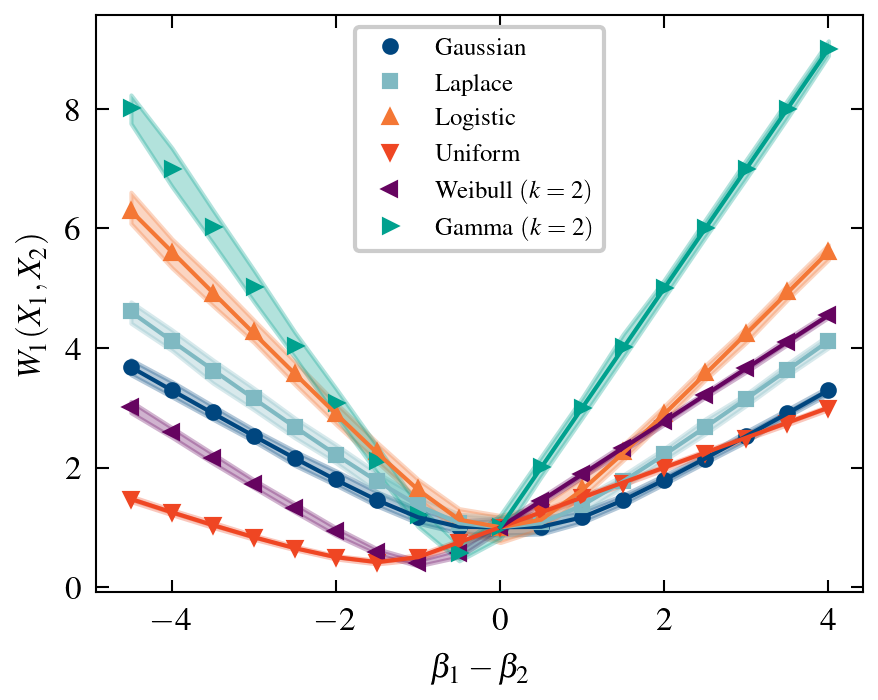

In [2]:
with open('data/scale_wasserstein.pkl', 'rb') as f:
    E_W_G, E_W_Lap, E_W_Log, E_W_U, E_W_Gam, E_W_Weib,\
       W_G, W_Lap, W_Log, W_Uni, W_Gam, W_Weib,\
       N, k,N_r,α_1,α_2,β_1,β_2 = pkl.load(f)

fig, axes = plt.subplots()
axes.plot(β_1 - β_2, E_W_G.mean(axis=0),
           label = "Gaussian", linestyle = '')
axes.plot(β_1 - β_2, E_W_Lap.mean(axis=0),
           label = "Laplace", linestyle = '')
axes.plot(β_1 - β_2, E_W_Log.mean(axis=0),
           label = "Logistic", linestyle = '')
axes.plot(β_1 - β_2, E_W_U.mean(axis=0),
           label = "Uniform", linestyle = '')
axes.plot(β_1 - β_2, E_W_Weib.mean(axis=0),
           label = "Weibull $(k={})$".format(k), linestyle = '')
axes.plot(β_1 - β_2, E_W_Gam.mean(axis=0),
           label = "Gamma $(k={})$".format(k), linestyle = '')


axes.plot(β_1 - β_2, W_G, 
          linestyle = ls[0], marker = '', color= cpal[0])
axes.plot(β_1 - β_2, W_Lap,
          linestyle = ls[0], marker = '', color= cpal[1])
axes.plot(β_1 - β_2, W_Log,
          linestyle = ls[0], marker = '', color= cpal[2])
axes.plot(β_1 - β_2, W_Uni,
          linestyle = ls[0], marker = '', color= cpal[3])
axes.plot(β_1 - β_2, W_Weib,
          linestyle = ls[0], marker = '', color= cpal[4])
axes.plot(β_1 - β_2, W_Gam,
          linestyle = ls[0], marker = '', color= cpal[5])



q = 0.95
axes.fill_between(β_1 - β_2,
                  np.quantile(E_W_G,(1-q)/2, axis = 0),
                  np.quantile(E_W_G,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[0], zorder = 0)
axes.fill_between(β_1 - β_2,
                  np.quantile(E_W_Lap,(1-q)/2, axis = 0),
                  np.quantile(E_W_Lap,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[1], zorder = 0)
axes.fill_between(β_1 - β_2,
                  np.quantile(E_W_Log,(1-q)/2, axis = 0),
                  np.quantile(E_W_Log,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[2], zorder = 0)
axes.fill_between(β_1 - β_2,
                  np.quantile(E_W_U,(1-q)/2, axis = 0),
                  np.quantile(E_W_U,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[3], zorder = 0)
axes.fill_between(β_1 - β_2,
                  np.quantile(E_W_Weib,(1-q)/2, axis = 0),
                  np.quantile(E_W_Weib,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[4], zorder = 0)
axes.fill_between(β_1 - β_2,
                  np.quantile(E_W_Gam,(1-q)/2, axis = 0),
                  np.quantile(E_W_Gam,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[5], zorder = 0)


axes.legend();
axes.set_xlabel(r"$\beta_1 - \beta_2$");
axes.set_ylabel(r"$W_1(X_1,X_2)$");
fig.savefig("figures/X1_{}_{}_X2_{}_sig.pdf".format(α_1,β_1,α_2))

In [5]:
np.random.seed(123)
N = 10000
k = 2
N_r = 100
α_1 = 5
α_2 = np.arange(0,10,0.5)
β_1 = 5
β_2 = 3


E_W_G = np.array([
    np.array([
        ot.emd2_1d(
            st.norm.rvs(loc = α_1, scale = β_1, size = N),
            st.norm.rvs(loc = x, scale = β_2, size = N), 
            metric = 'euclidean')
              for x in α_2]) for _ in range(N_r)])

E_W_Lap = np.array([
    np.array([
        ot.emd2_1d(
            st.laplace.rvs(loc = α_1, scale = β_1, size = N),
            st.laplace.rvs(loc = x, scale = β_2, size = N), 
            metric = 'euclidean')
              for x in α_2]) for _ in range(N_r)])

E_W_Log = np.array([
    np.array([
        ot.emd2_1d(
            st.logistic.rvs(loc = α_1, scale = β_1, size = N),
            st.logistic.rvs(loc = x, scale = β_2, size = N), 
            metric = 'euclidean')
              for x in α_2]) for _ in range(N_r)])

E_W_U = np.array([
    np.array([
        ot.emd2_1d(
            st.uniform.rvs(loc = α_1, scale = β_1, size = N),
            st.uniform.rvs(loc = x, scale = β_2, size = N), 
            metric = 'euclidean')
              for x in α_2]) for _ in range(N_r)])

E_W_Weib = np.array([
    np.array([
        ot.emd2_1d(
            st.weibull_min.rvs(k,loc = α_1, scale = β_1, size = N),
            st.weibull_min.rvs(k,loc = x, scale = β_2, size = N), 
            metric = 'euclidean')
              for x in α_2]) for _ in range(N_r)])

E_W_Gam = np.array([
    np.array([
        ot.emd2_1d(
            st.gamma.rvs(k,loc = α_1, scale = β_1, size = N),
            st.gamma.rvs(k,loc = x, scale = β_2, size = N), 
            metric = 'euclidean')
              for x in α_2]) for _ in range(N_r)])

E_W_Lognorm = np.array([
    np.array([
        ot.emd2_1d(
            st.lognorm.rvs(s=1,loc = α_1, scale = β_1, size = N),
            st.lognorm.rvs(s=1,loc = x, scale = β_2, size = N), 
            metric = 'euclidean')
              for x in α_2]) for _ in range(N_r)])

W_G = np.array([calc_Gaus(α_1,x,β_1,β_2) for x in α_2])
W_Lap = np.array([calc_Lap(α_1,x,β_1,β_2) for x in α_2])
W_Log = np.array([calc_Log(α_1,x,β_1,β_2) for x in α_2])
W_Uni = np.array([calc_Uni(α_1,x,β_1,β_2) for x in α_2])
W_Weib = np.array([calc_Weib(α_1,x,β_1,β_2,k) for x in α_2])
W_Gam = np.array([calc_Gam(α_1,x,β_1,β_2,k) for x in α_2])

res = [E_W_G, E_W_Lap, E_W_Log, E_W_U, E_W_Weib, E_W_Gam, E_W_Lognorm,
       W_G, W_Lap, W_Log, W_Uni, W_Weib, W_Gam,
       N, k,N_r,α_1,α_2,β_1,β_2]
with open('data/loc_wasserstein.pkl', 'wb') as f:
    pkl.dump(res, f)

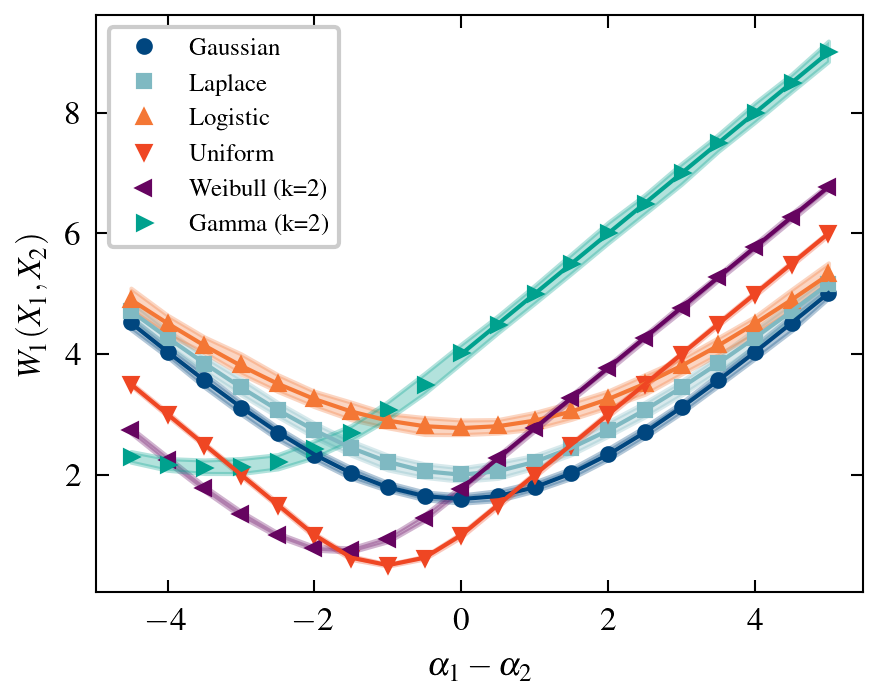

In [3]:
with open('data/loc_wasserstein.pkl', 'rb') as f:
    E_W_G, E_W_Lap, E_W_Log, E_W_U, E_W_Weib, E_W_Gam, E_W_Lognorm,\
       W_G, W_Lap, W_Log, W_Uni, W_Weib, W_Gam,\
       N, k,N_r,α_1,α_2,β_1,β_2 = pkl.load(f)
    
fig, axes = plt.subplots()
axes.plot(α_1 - α_2, E_W_G.mean(axis=0),
           label = "Gaussian", linestyle = '')
axes.plot(α_1 - α_2, E_W_Lap.mean(axis=0),
           label = "Laplace", linestyle = '')
axes.plot(α_1 - α_2, E_W_Log.mean(axis=0),
           label = "Logistic", linestyle = '')
axes.plot(α_1 - α_2, E_W_U.mean(axis=0),
           label = "Uniform", linestyle = '')
axes.plot(α_1 - α_2, E_W_Weib.mean(axis=0),
           label = "Weibull (k={})".format(k), linestyle = '')
axes.plot(α_1 - α_2, E_W_Gam.mean(axis=0),
           label = "Gamma (k={})".format(k), linestyle = '')

axes.plot(α_1 - α_2, W_G,
           linestyle = ls[0], marker = '', color= cpal[0])
axes.plot(α_1 - α_2, W_Lap, 
          linestyle = ls[0], marker = '', color= cpal[1])
axes.plot(α_1 - α_2, W_Log, 
          linestyle = ls[0], marker = '', color= cpal[2])
axes.plot(α_1 - α_2, W_Uni, 
          linestyle = ls[0], marker = '', color= cpal[3])
axes.plot(α_1 - α_2, W_Weib, 
          linestyle = ls[0], marker = '', color= cpal[4])
axes.plot(α_1 - α_2, W_Gam, 
          linestyle = ls[0], marker = '', color= cpal[5])

q = 0.95
axes.fill_between(α_1 - α_2,
                  np.quantile(E_W_G,(1-q)/2, axis = 0),
                  np.quantile(E_W_G,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[0], zorder = 0)
axes.fill_between(α_1 - α_2,
                  np.quantile(E_W_Lap,(1-q)/2, axis = 0),
                  np.quantile(E_W_Lap,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[1], zorder = 0)
axes.fill_between(α_1 - α_2,
                  np.quantile(E_W_Log,(1-q)/2, axis = 0),
                  np.quantile(E_W_Log,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[2], zorder = 0)
axes.fill_between(α_1 - α_2,
                  np.quantile(E_W_U,(1-q)/2, axis = 0),
                  np.quantile(E_W_U,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[3], zorder = 0)
axes.fill_between(α_1 - α_2,
                  np.quantile(E_W_Weib,(1-q)/2, axis = 0),
                  np.quantile(E_W_Weib,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[4], zorder = 0)
axes.fill_between(α_1 - α_2,
                  np.quantile(E_W_Gam,(1-q)/2, axis = 0),
                  np.quantile(E_W_Gam,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[5], zorder = 0)

axes.legend();
axes.set_xlabel(r"$\alpha_1 - \alpha_2$");
axes.set_ylabel(r"$W_1(X_1,X_2)$");
fig.savefig("figures/X1_{}_{}_X2_mu_{}.pdf".format(α_1,β_1,β_2))

## Univariate Gaussians

\begin{align}
        W_1^{UB}(X_1,X_2) &= \lvert\mu_y\rvert + \sqrt{\frac{2}{\pi}}\lvert\sigma_y\rvert \\

        W_1^{UB1}(X_1,X_2) &= \lvert\mu_y\rvert + \lvert\sigma_y\rvert \\

        W_1^{UB2}(X_1,X_2) &= \sqrt{\mu_y^2 + \sigma_y^2}\\

            W_1(X_1,X_2) &= \lvert\mu_y\rvert \left[ 1- 2 \Phi\left(-\frac{\lvert\mu_y\rvert}{\lvert\sigma_y\rvert}\right) \right]
              + \lvert\sigma_y\rvert \sqrt{\frac{2}{\pi}} \exp{\left(-\frac{\mu_y^2}{2\sigma_y^2}\right)}\\

        \lim_{\sigma_y \to 0 | \mu_y \to \infty/-\infty} W_1(X_1,X_2) &= W_1^{LB}(X_1,X_2) \\
        \lim_{ \sigma_y  \to \infty |  \mu_y  \to 0 } W_1(X_1,X_2) &= W_1^{Lim}(X_1,X_2)
\end{align}

In [7]:
def calc_W(μ_a,μ_b,σ_a,σ_b):
    # computes theoretical wasserstein distance between A~N(μ_a,σ_a²) and B~N(μ_b,σ_b²)
    # equivalent to folded normal with μ = |μ_a-μ_b| and σ = |σ_a-σ_b|
    μ  = np.abs(μ_a-μ_b)
    σ = np.abs(σ_a - σ_b)
    if σ:
        W =  σ*np.sqrt(2/np.pi)*np.exp(-μ**2/(2*σ**2)) + μ*(1-2*st.norm.cdf(-μ/σ))
    else:
        W = μ
    W_LB = np.abs(μ_a-μ_b)
    W_UB = np.abs(μ_a-μ_b) + np.abs(σ_a-σ_b)*np.sqrt(2/np.pi)
    return W, W_LB, W_UB

def calc_W2(μ_a,μ_b,σ_a,σ_b):
    # computes theoretical 2-wasserstein distance between A~N(μ_a,σ_a²) and B~N(μ_b,σ_b²)
    μ  = np.abs(μ_a-μ_b)
    σ = np.abs(σ_a - σ_b)
    W = μ**2 + σ**2
    return W

def calc_E(μ_a,μ_b,σ_a,σ_b, N_r=10, N_s = 10000):
    W1 = np.zeros(N_r)
    W2 = np.zeros(N_r)
    
    for i in range(N_r):
        μ = np.array([μ_a,μ_b])
        Σ = np.array([σ_a**2,σ_b**2])*np.identity(2)
        X = np.random.multivariate_normal(μ,Σ,N_s)
        W1[i] = ot.emd2_1d(X[:,0], X[:,1], metric = 'euclidean')
        W2[i] = ot.emd2_1d(X[:,0], X[:,1], metric = 'sqeuclidean')
    return  W1, W2

In [8]:
# Run simulations
np.random.seed(0)
N_r = 10 # number of simulations
N_s = 10000 # number of samples

# data range
μ_1 = np.arange(0,10,1)
μ_2 = np.arange(0,10,1)
σ_1 = np.arange(0,10,1)
σ_2 = np.arange(0,10,1)

# Simulated values (E)
E_W_MAE = np.zeros((len(μ_1),len(σ_1),len(μ_2),len(σ_2),N_r))
E_W_MSE = np.zeros_like(E_W_MAE)

# Calculated values
W_MAE = np.zeros((len(μ_1),len(σ_1),len(μ_2),len(σ_2)))
W_MSE = np.zeros_like(W_MAE)
W_UB = np.zeros_like(W_MAE)
W_LB = np.zeros_like(W_MAE)

for comb in tqdm(product(range(len(μ_1)),range(len(σ_1)),range(len(μ_2)),range(len(σ_2)))):
    W_MAE[comb],W_LB[comb],W_UB[comb] = calc_W(μ_1[comb[0]],μ_2[comb[2]],σ_1[comb[1]],σ_2[comb[3]])
    W_MSE[comb] = calc_W2(μ_1[comb[0]],μ_2[comb[2]],σ_1[comb[1]],σ_2[comb[3]])
    E_W_MAE[comb], E_W_MSE[comb] =\
          calc_E(μ_1[comb[0]],μ_2[comb[2]],σ_1[comb[1]],σ_2[comb[3]], N_r, N_s) 

res = [E_W_MAE, E_W_MSE, W_MAE, W_MSE, W_UB, W_LB,μ_1,μ_2, σ_1,σ_2, N_r, N_s]
with open('data/norm_wasserstein.pkl', 'wb') as f:
    pkl.dump(res, f)

0it [00:00, ?it/s]

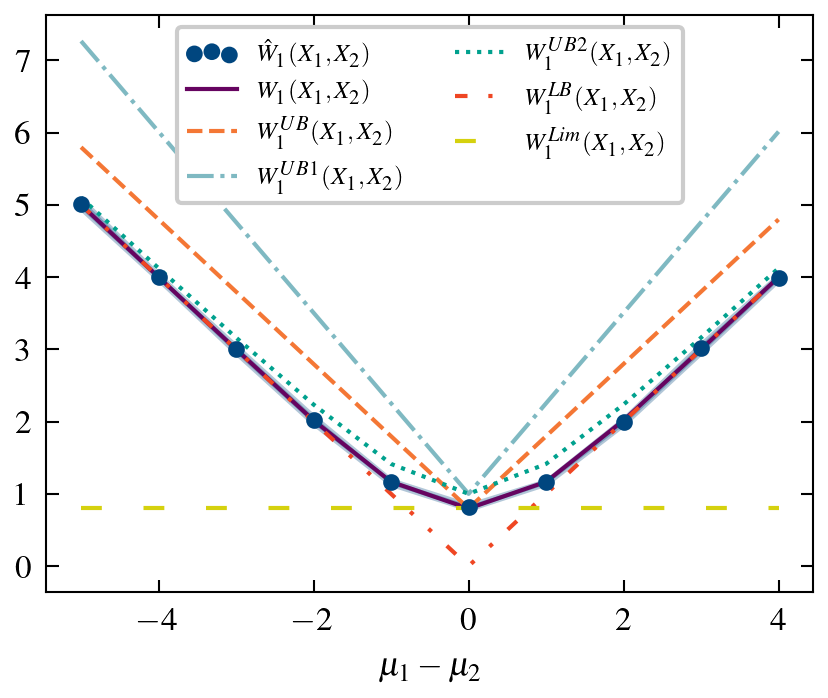

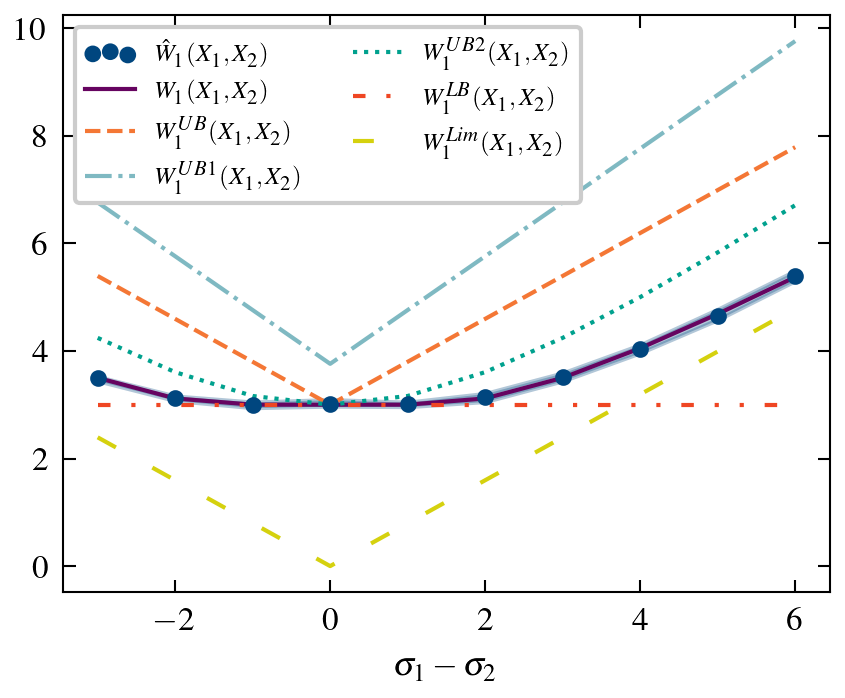

In [7]:
with open('data/norm_wasserstein.pkl', 'rb') as f:
    E_W_MAE, E_W_MSE, W_MAE, W_MSE, W_UB, W_LB,μ_1,μ_2, σ_1,σ_2, N_r, N_s = pkl.load(f)

q = 0.95
fig, ax = plt.subplots()
j = 2
k = 5
l = 3
x = μ_1-μ_2[k]
ax.fill_between(x, np.quantile(E_W_MAE[:,j,k,l],(1-q)/2, axis = 1),np.quantile(E_W_MAE[:,j,k,l],1-(1-q)/2, axis = 1), alpha = 0.3, color= cpal[0], zorder = 0)
ax.scatter(x, E_W_MAE[:,j,k,l].mean(axis=1),label = "$\hat W_1(X_1,X_2)$", color = cpal[0],  zorder = 10)
ax.plot(x,W_MAE[:,j,k,l], label = "$W_1(X_1,X_2)$", marker = '', color = cpal[4],zorder = 5)
ax.plot(x,W_UB[:,j,k,l], label = "$W_1^{UB}(X_1,X_2)$", marker = '', color = cpal[2], zorder = 5)
ax.plot(x,W_UB[:,j,k,l]/(np.sqrt(2/np.pi)), label = "$W_1^{UB1}(X_1,X_2)$", marker = '', color = cpal[1], zorder = 5)
ax.plot(x,np.sqrt(W_MSE[:,j,k,l]), label = "$W_1^{UB2}(X_1,X_2)$", marker = '', color = cpal[5], zorder = 5)
ax.plot(x,W_LB[:,j,k,l], label = "$W_1^{LB}(X_1,X_2)$", marker = '', color = cpal[3],zorder = 5)
ax.plot(x,np.ones(len(x))*np.abs(σ_1[j]-σ_2[l])*(np.sqrt(2/np.pi)), label = "$W_1^{Lim}(X_1,X_2)$",  marker = '', color = cpal[6], zorder = 5)
ax.set_xlabel("$\mu_1 - \mu_2$")
ax.legend(ncol=2);
fig.savefig("figures/X1_N_mu_{}_X2_N_{}_{}.pdf".format(σ_1[j],μ_2[k],σ_2[l]))

fig, ax = plt.subplots()
i = 2
l = 3
x = σ_1-σ_2[l]

ax.fill_between(x, np.quantile(E_W_MAE[i,:,k,l],(1-q)/2, axis = 1),np.quantile(E_W_MAE[i,:,k,l],1-(1-q)/2, axis = 1), alpha = 0.3, color= cpal[0], zorder = 0)
ax.scatter(x, E_W_MAE[i,:,k,l].mean(axis=1),label = "$\hat W_1(X_1,X_2)$", color = cpal[0],  zorder = 10)
ax.plot(x,W_MAE[i,:,k,l], label = "$W_1(X_1,X_2)$",  marker = '', color = cpal[4],zorder = 5)
ax.plot(x,W_UB[i,:,k,l], label = "$W_1^{UB}(X_1,X_2)$",  marker = '', color = cpal[2], zorder = 5)
ax.plot(x,W_UB[i,:,k,l]/(np.sqrt(2/np.pi)), label = "$W_1^{UB1}(X_1,X_2)$",  marker = '', color = cpal[1], zorder = 5)
ax.plot(x,np.sqrt(W_MSE[i,:,k,l]), label = "$W_1^{UB2}(X_1,X_2)$", marker = '', color = cpal[5], zorder = 5)
ax.plot(x,W_LB[i,:,k,l], label = "$W_1^{LB}(X_1,X_2)$",  marker = '', color = cpal[3],zorder = 5)
ax.plot(x,np.abs(x)*(np.sqrt(2/np.pi)), label = "$W_1^{Lim}(X_1,X_2)$",  marker = '', color = cpal[6], zorder = 5)
ax.set_xlabel("$\sigma_1 - \sigma_2$")
ax.legend(ncol=2);
fig.savefig("figures/X1_N_{}_sig_X2_N_{}_{}.pdf".format(μ_1[i],μ_2[k],σ_2[l]))

## Effect of Differential Privacy on 1-Wasserstein Distance

The data to be purchased can be differentially-private through noise addition ($\epsilon$-DP using the Laplace mechanism or $(\epsilon,\delta)$-DP using the Gaussian mechanism).

Gaussian Mechanism:
\begin{align} 
    W_1(X_1,X_2) + W_1^{UB}(X_N,\delta_0) &= W(X_1,X_2) + \frac{\sqrt{2\ln(1.25/\delta)}\Delta}{\epsilon}\\
    W_1(X_1,X_2) + W_1(X_N,\delta_0)  &= \frac{2\Delta}{\epsilon}\sqrt{\frac{\ln(1.25/\delta)}{\pi}} \\
    W(X_1 +X_{N},X_2) & =  \lvert\mu_y\rvert \left[ 1- 2 \Phi\left(-\frac{\lvert\mu_y\rvert}{\lvert\sigma_y\rvert}\right) \right] + \lvert\sigma_y\rvert \sqrt{\frac{2}{\pi}} \exp{\left(-\frac{\mu_y^2}{2\sigma_y^2}\right)}\\
\end{align}
where $\mu_y = \mu_1 - \mu2, \sigma_y = \sigma_{DP} - \sigma_2$ and $\sigma_{DP} = \sqrt{\sigma_1^2 + \frac{2\ln(1.25/\delta)\Delta^2}{\epsilon^2}}$.

Laplace Mechanism

\begin{align}
    W_1(X_1,X_2) + W_1^{UB}(X_L,\delta_0) &= W(X_1,X_2) + \frac{\sqrt{2}\Delta}{\epsilon}\\
    W_1(X_1,X_2) + W_1(X_L,\delta_0) &= W(X_1,X_2) + \frac{\Delta}{\epsilon}\\
    W(X_1 + X_G, X_2)  &=  \lvert\mu_1 - \mu_2\rvert \left[ 1- 2 \Phi\left(\frac{-\lvert\mu_1 - \mu_2\rvert}{\lvert\sigma_{DP}-\sigma_2\rvert}\right) \right]
        + \lvert\sigma_{DP}-\sigma_2\rvert \sqrt{\frac{2}{\pi}} \exp{\left(\frac{-\left(\mu_1 - \mu_2\right)^2}{2\left(\sigma_{DP}-\sigma_2\right)^2}\right)}
\end{align}
where $X_G \sim N(0,2\frac{\Delta^2}{\epsilon^2})$ and $\sigma_{DP} = \sqrt{\sigma_1^2 + 2\frac{\Delta^2}{\epsilon^2}}$

In [10]:
def calc_W(μ_a,μ_b,σ_a,σ_b):
    # computes theoretical wasserstein distance between A~N(μ_a,σ_a²) and B~N(μ_b,σ_b²)
    # equivalent to folded normal with μ = |μ_a-μ_b| and σ = |σ_a-σ_b|
    μ  = np.abs(μ_a-μ_b)
    σ = np.abs(σ_a - σ_b)
    if σ:
        W =  σ*np.sqrt(2/np.pi)*np.exp(-μ**2/(2*σ**2)) + μ*(1-2*st.norm.cdf(-μ/σ))
    else:
        W = μ
    W_LB = np.abs(μ_a-μ_b)
    W_UB = np.abs(μ_a-μ_b) + np.abs(σ_a-σ_b)*np.sqrt(2/np.pi)
    return W, W_LB, W_UB

np.random.seed(0)
ϵ = np.array([1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01])
Δ = 1
δ = 10e-2

μ_p = np.arange(10)
σ_p = np.arange(10)

μ_y = 3
σ_y = 2

N_r = 100
N_s = 10000

W_PY = np.zeros((len(μ_p),len(σ_p),len(ϵ)))
W_PXY_N = np.zeros((len(μ_p),len(σ_p),len(ϵ)))
W_PXY_L = np.zeros((len(μ_p),len(σ_p),len(ϵ)))
E_W_PY = np.zeros((len(μ_p),len(σ_p),len(ϵ),N_r))
E_W_PXY_N = np.zeros_like(E_W_PY)
E_W_PXY_L = np.zeros_like(E_W_PY)

Y = np.random.normal(μ_y,σ_y,N_s)
for comb in tqdm(product(range(len(μ_p)),range(len(σ_p)),range(len(ϵ)))):
    W_PY[comb] = calc_W(μ_p[comb[0]],μ_y,σ_p[comb[1]],σ_y)[0]
    σ_x = np.sqrt(2*np.log(1.25/δ)*Δ**2/ϵ[comb[2]]**2)
    σ_px = np.sqrt(σ_p[comb[1]]**2 + σ_x**2)
    σ_pl = np.sqrt(σ_p[comb[1]]**2 + 2*(Δ/ϵ[comb[2]])**2)
    W_PXY_N[comb] = calc_W(μ_p[comb[0]],μ_y,σ_px,σ_y)[0]
    W_PXY_L[comb] = calc_W(μ_p[comb[0]],μ_y,σ_pl,σ_y)[0]
    for r in range(N_r):
        X_L = np.random.laplace(0,Δ/ϵ[comb[2]], N_s) # Lap(μ = 0, b = Δ/ϵ)
        μ_n = np.array([μ_p[comb[0]],0])
        Σ_n = np.array([σ_p[comb[1]]**2,σ_x**2])*np.identity(2)
        X = np.random.multivariate_normal(μ_n,Σ_n,N_s)
        P = X[:,0]
        X_N = X[:,1]
        E_W_PY[comb+(r,)] = ot.emd2_1d(Y, P, metric = 'euclidean')
        E_W_PXY_L[comb+(r,)] = ot.emd2_1d(Y, P+X_L, metric = 'euclidean')
        E_W_PXY_N[comb+(r,)] = ot.emd2_1d(Y, P+X_N, metric = 'euclidean')
res = [W_PY, W_PXY_N, W_PXY_L, E_W_PY, E_W_PXY_N, E_W_PXY_L, μ_p, σ_p, μ_p, σ_p, ϵ,Δ,δ, N_s, N_r]
with open('data/dp_norm.pkl', 'wb') as f:
    pkl.dump(res, f)       

0it [00:00, ?it/s]

### Laplace Mechansim

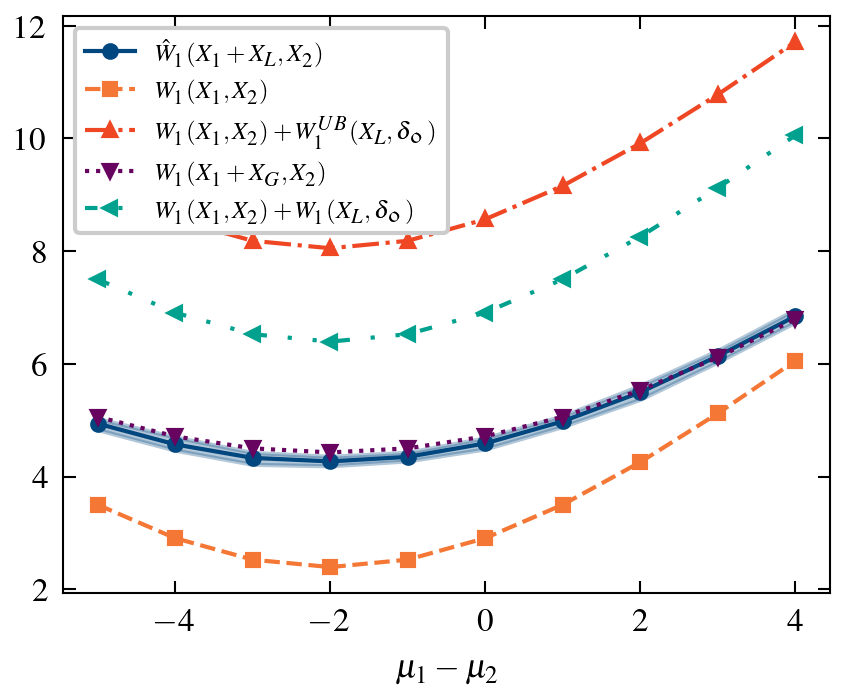

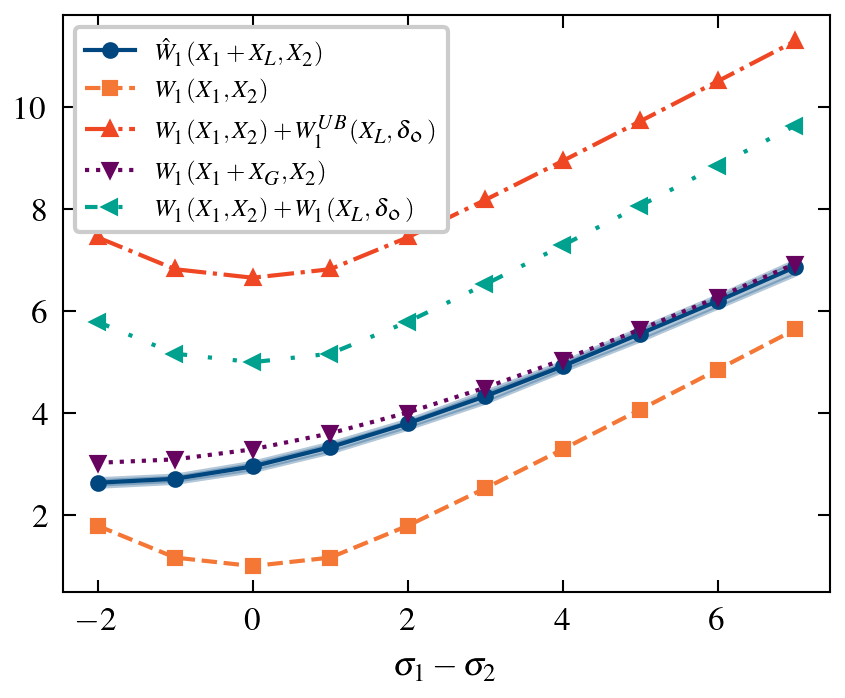

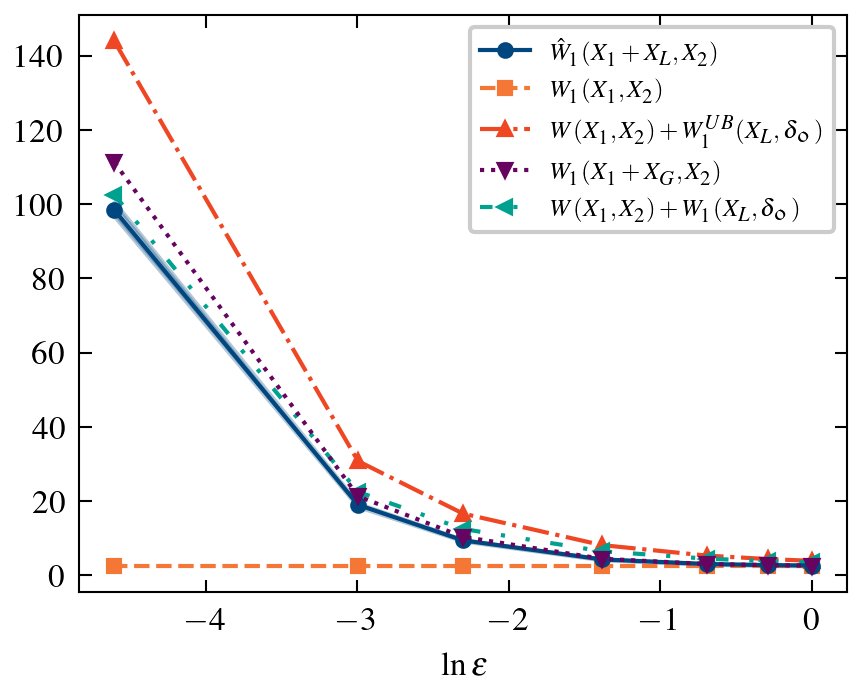

In [8]:
# Plot effect of differential privacy
with open('data/dp_norm.pkl', 'rb') as f:
    W_PY, W_PXY_N, W_PXY_L, E_W_PY, E_W_PXY_N, E_W_PXY_L, μ_p, σ_p, μ_p, σ_p,ϵ,Δ,δ, N_s, N_r = pkl.load(f)

# target distribution
μ_y = 5
σ_y = 2

# Difference between X and target Y (fixed value)
# E[|X_1 - Y|] <= L⋅W(X_1, Y)
fig, ax = plt.subplots()
x = μ_p-μ_y
j = 5
k = 3
q = 0.95
ax.fill_between(x, np.quantile(E_W_PXY_L[:,j,k],(1-q)/2, axis=1),np.quantile(E_W_PXY_L[:,j,k],1-(1-q)/2, axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
ax.plot(x, E_W_PXY_L[:,j,k].mean(axis=1),label = "$\hat W_1(X_1+X_L,X_2)$", color = cpal[0],  zorder = 10)
ax.plot(x, W_PY[:,j,k],label = "$W_1(X_1,X_2)$", color = cpal[2],  zorder = 5)
ax.plot(x, W_PY[:,j,k]+ np.sqrt(2)*Δ/ϵ[k],label = "$W_1(X_1,X_2) + W_1^{UB}(X_L,\mathfrak{\delta_0})$", color = cpal[3],  zorder = 5)
ax.plot(x, W_PXY_L[:,j,k],label = "$W_1(X_1+X_G,X_2)$", color = cpal[4],  zorder = 50)
ax.plot(x, W_PY[:,j,k]+ Δ/ϵ[k],label = "$W_1(X_1,X_2) + W_1(X_L,\mathfrak{\delta_0})$", color = cpal[5],  zorder = 5)
ax.set_xlabel("$\mu_1 - \mu_2$")
ax.legend();    
fig.savefig("figures/DP_P_N_mu_{}_Y_N_{}_{}_e_L_{}.pdf".format(σ_p[j],μ_y,σ_y, k))

fig, ax = plt.subplots()
x = σ_p-σ_y
i = 2
ax.fill_between(x, np.quantile(E_W_PXY_L[i,:,k],(1-q)/2, axis=1),np.quantile(E_W_PXY_L[i,:,k],1-(1-q)/2, axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
ax.plot(x, E_W_PXY_L[i,:,k].mean(axis=1),label = "$\hat W_1(X_1+X_L,X_2)$", color = cpal[0],  zorder = 10)
ax.plot(x, W_PY[i,:,k],label = "$W_1(X_1,X_2)$", color = cpal[2],  zorder = 5)
ax.plot(x, W_PY[i,:,k]+ np.sqrt(2)*Δ/ϵ[k],label = "$W_1(X_1,X_2) + W_1^{UB}(X_L,\mathfrak{\delta_0})$", color = cpal[3],  zorder = 5)
ax.plot(x, W_PXY_L[i,:,k],label = "$W_1(X_1+X_G,X_2)$", color = cpal[4],  zorder = 50)
ax.plot(x, W_PY[i,:,k]+ Δ/ϵ[k],label = "$W_1(X_1,X_2) + W_1(X_L,\mathfrak{\delta_0})$", color = cpal[5],  zorder = 5)
ax.set_xlabel("$\sigma_1 - \sigma_2$");
ax.legend();    
fig.savefig("figures/DP_P_N_{}_sig_Y_N_{}_{}_e_L_{}.pdf".format(μ_p[i],μ_y,σ_y, k))

fig, ax = plt.subplots()
E_W_XY_L = E_W_PXY_L- E_W_PY
ax.fill_between(np.log(ϵ), np.quantile(E_W_PXY_L[i,j,:],(1-q)/2, axis=1),np.quantile(E_W_PXY_L[i,j,:],1-(1-q)/2, axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
ax.plot(np.log(ϵ), E_W_PXY_L[i,j,:].mean(axis=1),label = "$\hat W_1(X_1+X_L,X_2)$", color = cpal[0],  zorder = 10)
ax.plot(np.log(ϵ), W_PY[i,j,:],label = "$W_1(X_1,X_2)$", color = cpal[2],  zorder = 5)
ax.plot(np.log(ϵ), W_PY[i,j,:] + np.sqrt(2)*Δ/ϵ,label = "$W(X_1,X_2) + W_1^{UB}(X_L,\mathfrak{\delta_0})$", color = cpal[3],  zorder = 5)
ax.plot(np.log(ϵ), W_PXY_L[i,j,:],label = "$W_1(X_1+X_G,X_2)$", color = cpal[4],  zorder = 50)
ax.plot(np.log(ϵ), W_PY[i,j,:] + Δ/ϵ,label = "$W(X_1,X_2) + W_1(X_L,\mathfrak{\delta_0})$", color = cpal[5],  zorder = 5)
ax.set_xlabel("$\ln\epsilon$");
ax.legend();    
fig.savefig("figures/DP_P_N_{}_{}_Y_N_{}_{}_e_L.pdf".format(μ_p[i],σ_p[j],μ_y,σ_y))

### Gaussian Mechanism

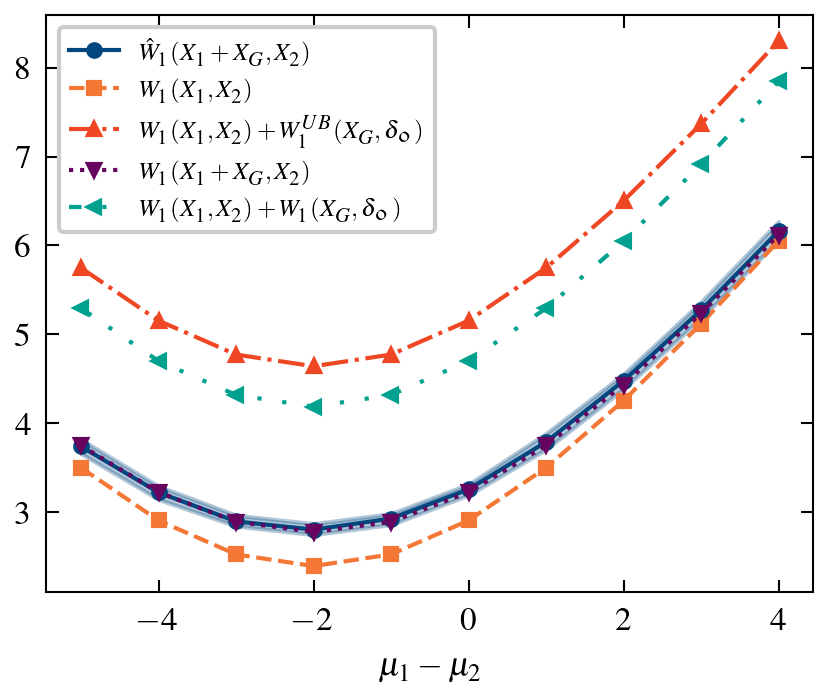

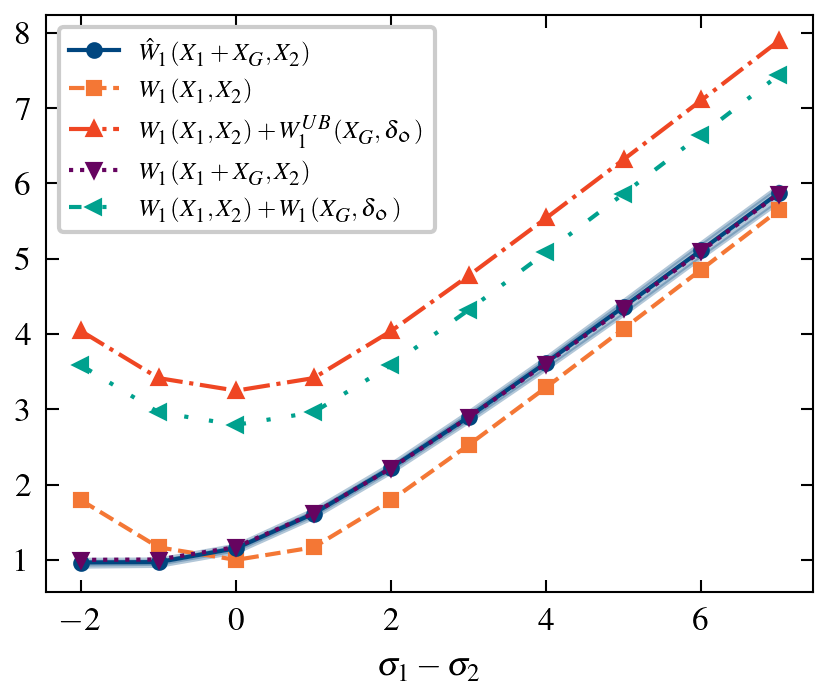

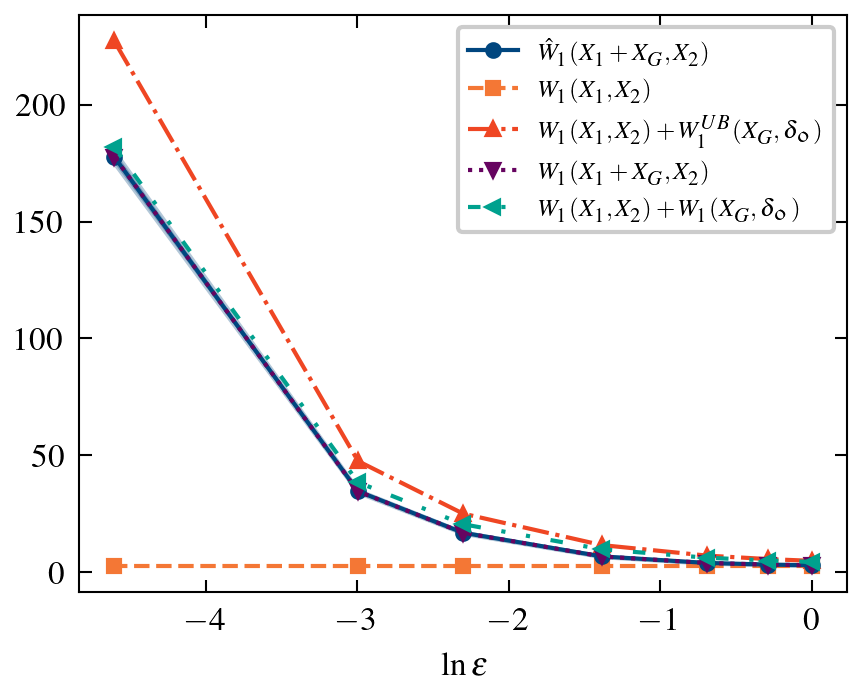

In [9]:
with open('data/dp_norm.pkl', 'rb') as f:
    W_PY, W_PXY_N, W_PXY_L, E_W_PY, E_W_PXY_N, E_W_PXY_L, μ_p, σ_p, μ_p, σ_p,ϵ,Δ,δ, N_s, N_r = pkl.load(f)

# Difference between X and target Y (fixed value)
# E[|X_1 - Y|] <= L⋅W(X_1, Y)
fig, ax = plt.subplots()
x = μ_p-μ_y
σ_n = np.sqrt(2*np.log(1.25/δ)*Δ**2/ϵ**2)
j = 5
k = 0
ax.fill_between(x, np.quantile(E_W_PXY_N[:,j,k],(1-q)/2, axis=1),np.quantile(E_W_PXY_N[:,j,k],1-(1-q)/2, axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
ax.plot(x, E_W_PXY_N[:,j,k].mean(axis=1),label = "$\hat W_1(X_1+X_G,X_2)$", color = cpal[0],  zorder = 10)
ax.plot(x, W_PY[:,j,k],label = "$W_1(X_1,X_2)$", color = cpal[2],  zorder = 5)
ax.plot(x, W_PY[:,j,k] + σ_n[k],label = "$W_1(X_1,X_2) + W_1^{UB}(X_G,\mathfrak{\delta_0})$", color = cpal[3],  zorder = 5)
ax.plot(x, W_PXY_N[:,j,k],label = "$W_1(X_1+X_G,X_2)$", color = cpal[4],  zorder = 50)
ax.plot(x, W_PY[:,j,k] + σ_n[k]*np.sqrt(2/np.pi),label = "$W_1(X_1,X_2) + W_1(X_G,\mathfrak{\delta_0})$", color = cpal[5],  zorder = 50)
ax.set_xlabel("$\mu_1 - \mu_2$")
ax.legend();    
fig.savefig("figures/DP_P_N_mu_{}_Y_N_{}_{}_e_N_{}.pdf".format(σ_p[j],μ_y,σ_y, k))

fig, ax = plt.subplots()
x = σ_p-σ_y
i = 2
ax.fill_between(x, np.quantile(E_W_PXY_N[i,:,k],(1-q)/2, axis=1),np.quantile(E_W_PXY_N[i,:,k],1-(1-q)/2, axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
ax.plot(x, E_W_PXY_N[i,:,k].mean(axis=1),label = "$\hat W_1(X_1+X_G,X_2)$", color = cpal[0],  zorder = 10)
ax.plot(x, W_PY[i,:,k],label = "$W_1(X_1,X_2)$", color = cpal[2],  zorder = 5)
ax.plot(x, W_PY[i,:,k] + σ_n[k],label = "$W_1(X_1,X_2) + W_1^{UB}(X_G,\mathfrak{\delta_0})$", color = cpal[3],  zorder = 5)
ax.plot(x, W_PXY_N[i,:,k],label = "$W_1(X_1+X_G,X_2)$", color = cpal[4],  zorder = 50)
ax.plot(x, W_PY[i,:,k] + σ_n[k]*np.sqrt(2/np.pi),label = "$W_1(X_1,X_2) + W_1(X_G,\mathfrak{\delta_0})$", color = cpal[5],  zorder = 50)
ax.set_xlabel("$\sigma_1 - \sigma_2$");
ax.legend();    
fig.savefig("figures/DP_P_N_{}_sig_Y_N_{}_{}_e_N_{}.pdf".format(μ_p[j],μ_y,σ_y, k))

fig, ax = plt.subplots()
E_W_XY_N = E_W_PXY_N - E_W_PY
ax.fill_between(np.log(ϵ), np.quantile(E_W_PXY_N[i,j,:],(1-q)/2, axis=1),np.quantile(E_W_PXY_N[i,j,:],1-(1-q)/2, axis=1), alpha = 0.3, color= cpal[0], zorder = 0)
ax.plot(np.log(ϵ), E_W_PXY_N[i,j,:].mean(axis=1),label = "$\hat W_1(X_1+X_G,X_2)$", color = cpal[0],  zorder = 10)
ax.plot(np.log(ϵ), W_PY[i,j,:],label = "$W_1(X_1,X_2)$", color = cpal[2],  zorder = 5)
ax.plot(np.log(ϵ), W_PY[i,j,:] + σ_n,label = "$W_1(X_1,X_2) + W_1^{UB}(X_G,\mathfrak{\delta_0})$", color = cpal[3],  zorder = 5)
ax.plot(np.log(ϵ), W_PXY_N[i,j,:],label = "$W_1(X_1+X_G,X_2)$", color = cpal[4],  zorder = 50)
ax.plot(np.log(ϵ), W_PY[i,j,:] + σ_n*np.sqrt(2/np.pi),label = "$W_1(X_1,X_2) + W_1(X_G,\mathfrak{\delta_0})$", color = cpal[5],  zorder = 50)
ax.set_xlabel("$\ln\epsilon$");
ax.legend();    
fig.savefig("figures/DP_P_N_{}_{}_Y_N_{}_{}_e_N.pdf".format(μ_p[i],σ_p[j],μ_y,σ_y))

## p-Wasserstein Distance

In [13]:
α_1 = 5
α_2 = 4
β_1 = 3
β_2 = 1
k=2
N = 10000
N_r = 1000
N_p = range(1,11)

E_W_G = np.array([
    np.array([np.power(
        ot.emd2_1d(
            st.norm.rvs(loc = α_1, scale = β_1, size = N),
            st.norm.rvs(loc = α_2, scale = β_2, size = N), 
            metric = 'minkowski', p = p),1/p)
              for p in N_p]) for _ in range(N_r)])
EP_W_G = np.array([
    np.array([np.power(np.mean(np.abs((α_1 - α_2) + (β_1-β_2)*st.norm.rvs(size = N))**p),1/p)
              for p in N_p]) for _ in range(N_r)])
E_W_Lap = np.array([
    np.array([np.power(
        ot.emd2_1d(
            st.laplace.rvs(loc = α_1, scale = β_1, size = N),
            st.laplace.rvs(loc = α_2, scale = β_2, size = N), 
            metric = 'minkowski', p = p),1/p)
              for p in N_p]) for _ in range(N_r)])
EP_W_Lap = np.array([
    np.array([np.power(np.mean(np.abs((α_1 - α_2) + (β_1-β_2)*st.laplace.rvs(size = N))**p),1/p)
              for p in N_p]) for _ in range(N_r)])
E_W_Log = np.array([
    np.array([np.power(
        ot.emd2_1d(
            st.logistic.rvs(loc = α_1, scale = β_1, size = N),
            st.logistic.rvs(loc = α_2, scale = β_2, size = N), 
            metric = 'minkowski', p = p),1/p)
              for p in N_p]) for _ in range(N_r)])
EP_W_Log = np.array([
    np.array([np.power(np.mean(np.abs((α_1 - α_2) + (β_1-β_2)*st.logistic.rvs(size = N))**p),1/p)
              for p in N_p]) for _ in range(N_r)])

E_W_U = np.array([
    np.array([np.power(
        ot.emd2_1d(
            st.uniform.rvs(loc = α_1, scale = β_1, size = N),
            st.uniform.rvs(loc = α_2, scale = β_2, size = N), 
            metric = 'minkowski', p = p),1/p)
              for p in N_p]) for _ in range(N_r)])
EP_W_U = np.array([
    np.array([np.power(np.mean(np.abs((α_1 - α_2) + (β_1-β_2)*st.uniform.rvs(size = N))**p),1/p)
              for p in N_p]) for _ in range(N_r)])

E_W_Weib = np.array([
    np.array([np.power(
        ot.emd2_1d(
            st.weibull_min.rvs(k,loc = α_1, scale = β_1, size = N),
            st.weibull_min.rvs(k,loc = α_2, scale = β_2, size = N), 
            metric = 'minkowski', p = p),1/p)
              for p in N_p]) for _ in range(N_r)])
EP_W_Weib = np.array([
    np.array([np.power(np.mean(np.abs((α_1 - α_2) + (β_1-β_2)*st.weibull_min.rvs(k,size = N))**p),1/p)
              for p in N_p]) for _ in range(N_r)])
E_W_Gam = np.array([
    np.array([np.power(
        ot.emd2_1d(
            st.gamma.rvs(k,loc = α_1, scale = β_1, size = N),
            st.gamma.rvs(k,loc = α_2, scale = β_2, size = N), 
            metric = 'minkowski', p = p),1/p)
              for p in N_p]) for _ in range(N_r)])
EP_W_Gam = np.array([
    np.array([np.power(np.mean(np.abs((α_1 - α_2) + (β_1-β_2)*st.gamma.rvs(k,size = N))**p),1/p)
              for p in N_p]) for _ in range(N_r)])

res = [E_W_G, E_W_Lap, E_W_Log, E_W_U, E_W_Weib, E_W_Gam,
       EP_W_G, EP_W_Lap, EP_W_Log, EP_W_U, EP_W_Weib, EP_W_Gam,
       N, k,N_r, N_p,α_1,α_2,β_1,β_2]
with open('data/p_wasserstein.pkl', 'wb') as f:
    pkl.dump(res, f)

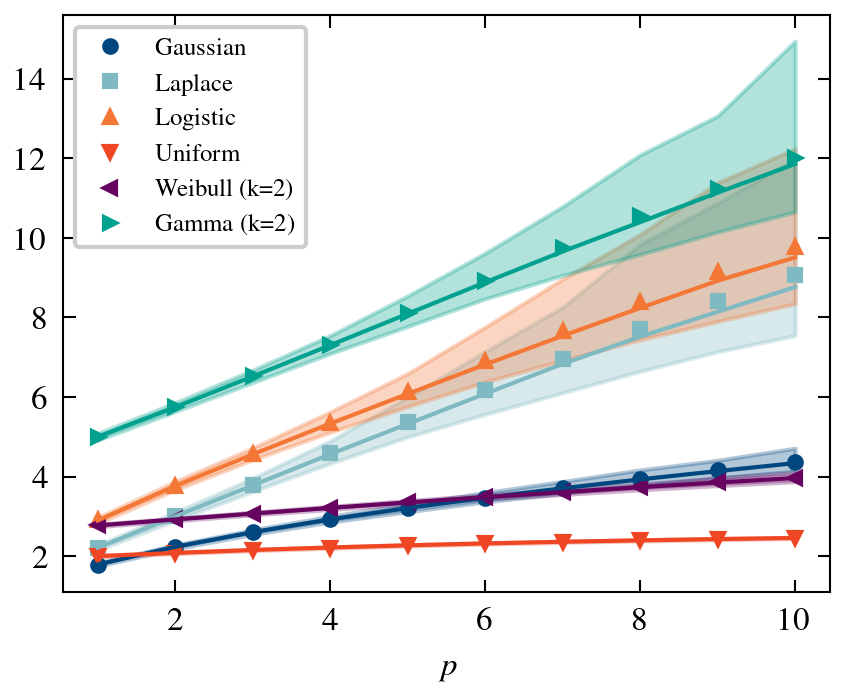

In [10]:
with open('data/p_wasserstein.pkl', 'rb') as f:
    E_W_G, E_W_Lap, E_W_Log, E_W_U, E_W_Weib, E_W_Gam,\
       EP_W_G, EP_W_Lap, EP_W_Log, EP_W_U, EP_W_Weib, EP_W_Gam,\
       N, k,N_r, N_p,α_1,α_2,β_1,β_2 = pkl.load(f)
    
fig, axes = plt.subplots()
axes.plot(N_p, E_W_G.mean(axis=0),
           label = "Gaussian", linestyle = '')
axes.plot(N_p, E_W_Lap.mean(axis=0),
           label = "Laplace", linestyle = '')
axes.plot(N_p, E_W_Log.mean(axis=0),
           label = "Logistic", linestyle = '')
axes.plot(N_p, E_W_U.mean(axis=0),
           label = "Uniform", linestyle = '')
axes.plot(N_p, E_W_Weib.mean(axis=0),
           label = "Weibull (k={})".format(k), linestyle = '')
axes.plot(N_p, E_W_Gam.mean(axis=0),
           label = "Gamma (k={})".format(k), linestyle = '')

axes.plot(N_p, EP_W_G.mean(axis=0),
           linestyle = ls[0], marker = '', color= cpal[0])
axes.plot(N_p, EP_W_Lap.mean(axis=0),
           linestyle = ls[0], marker = '', color= cpal[1])
axes.plot(N_p, EP_W_Log.mean(axis=0),
           linestyle = ls[0], marker = '', color= cpal[2])
axes.plot(N_p, EP_W_U.mean(axis=0), 
          linestyle = ls[0], marker = '', color= cpal[3])
axes.plot(N_p, EP_W_Weib.mean(axis=0), 
          linestyle = ls[0], marker = '', color= cpal[4])
axes.plot(N_p, EP_W_Gam.mean(axis=0), 
          linestyle = ls[0], marker = '', color= cpal[5])
q = 0.95
axes.fill_between(N_p,
                  np.quantile(E_W_G,(1-q)/2, axis = 0),
                  np.quantile(E_W_G,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[0], zorder = 0)
axes.fill_between(N_p,
                  np.quantile(E_W_Lap,(1-q)/2, axis = 0),
                  np.quantile(E_W_Lap,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[1], zorder = 0)
axes.fill_between(N_p,
                  np.quantile(E_W_Log,(1-q)/2, axis = 0),
                  np.quantile(E_W_Log,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[2], zorder = 0)
axes.fill_between(N_p,
                  np.quantile(E_W_U,(1-q)/2, axis = 0),
                  np.quantile(E_W_U,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[3], zorder = 0)
axes.fill_between(N_p,
                  np.quantile(E_W_Weib,(1-q)/2, axis = 0),
                  np.quantile(E_W_Weib,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[4], zorder = 0)
axes.fill_between(N_p,
                  np.quantile(E_W_Gam,(1-q)/2, axis = 0),
                  np.quantile(E_W_Gam,1-(1-q)/2, axis = 0),
                   alpha = 0.3, color= cpal[5], zorder = 0)

axes.legend();
axes.set_xlabel(r"$p$");
fig.savefig("figures/p_X1_{}_{}_X2_{}_{}.pdf".format(α_1,α_2,β_1,β_2))
